In [1]:
import torch
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

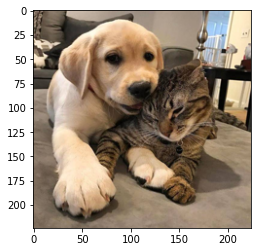

In [2]:
img_path = './image/cat_dog.jpeg'
# resize操作是为了和传入神经网络训练图片大小一致
img = Image.open(img_path).resize((224,224))
# 需要将原始图片转为np.float32格式并将像素值归一化在0-1之间
# transforms.Compose用的是什么将像素值归一化在0-1之间？
rgb_img = np.float32(img)/255
plt.imshow(img)

In [3]:
torch.cuda.is_available()

True

In [4]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
# pytorch_grad_cam自带的图像预处理操作
# 像素标准化—>通道变换—>unsqueeze(0)
# 这一过程也可以用input_tensor = transform(img)
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
print(input_tensor.shape)
# 数据和模型均移动至GPU
input_tensor = input_tensor.cuda()
model.cuda()
# 查看是否移过了
print(input_tensor.is_cuda)
print(next(model.parameters()).device)

torch.Size([1, 3, 224, 224])
True
cuda:0


注意：`tensor.cuda`会返回一个新对象，这个新对象的数据已转移至GPU，而之前的 tensor 还在原来的设备上（CPU）。而 `module.cuda`则会将所有的数据都迁移至 GPU，并返回自己。故`module = module.cuda()`和`module.cuda()`的作用一致。

In [5]:
output = model(input_tensor)
_, predict = torch.max(output.data, 1) 
predict

tensor([208], device='cuda:0')

In [6]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

`208` 狗, `Labrador retriever`

In [7]:
model.features[-1]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

(1, 224, 224)
(224, 224)
<class 'numpy.ndarray'>


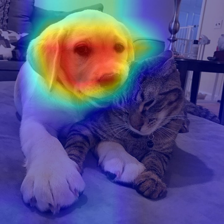

In [8]:
# 选择vgg16网络中feature模块的最后一层作为目标层
target_layers = [model.features[-1]]
# 初始化GradCAM，包括模型，目标层以及是否使用cuda
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
# 选定目标类别，如果不设置，则默认为分数最高的那一类
# targets = None 
targets = [ClassifierOutputTarget(predict)]
# 计算cam
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(grayscale_cam.shape)
# 展示热力图并保存, grayscale_cam是一个batch的结果，只能选择一张进行展示
grayscale_cam = grayscale_cam[0, :]
# grayscale_cam = grayscale_cam.squeeze(0)
print(grayscale_cam.shape)
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)

In [9]:
predict = torch.tensor([281])

`281` 猫, `tabby, tabby cat`

<class 'numpy.ndarray'>


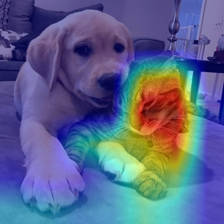

In [10]:
target_layers = [model.features[-1]]
cam = GradCAM(model=model,target_layers=target_layers)
targets = [ClassifierOutputTarget(predict)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
print(type(cam_img))
Image.fromarray(cam_img)